# Supplemental material: Cross-validation and regularization in Python
This Jupyter notebook contains supplemental code, text, and figures demonstrating how many of the methods described in the main text of Yarkoni & Westfall (2016) can be easily applied to one's data using off-the-shelf Python packages (most notably, [scikit-learn](http://scikit-learn.org)). This notebook was written for Python; a similar take in R is also [available](https://github.com/tyarkoni/fixme).

In [1]:
# Import the main packages we'll need. We'll import others we use
# only once or twice later.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline

# Ignore lack of convergence warnings--we don't care about these for our
# purposes, and we get a lot of them when doing the cross-validation.
import warnings
warnings.filterwarnings('ignore', message='Objective did not converge')

/Users/tal/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Getting the data
We'll use the classic "diabetes" dataset originally from Efron, Hastie, Johnstone, & Tibshirani (2004), and [available here](http://www4.stat.ncsu.edu/~boos/var.select/diabetes.html). The dataset contains 10 demographic and blood serum predictors, plus a continuous outcome measure of disease progression after one year. There are 442 cases, each representing a single individual.

In [2]:
# Data obtained from http://www4.stat.ncsu.edu/~boos/var.select/diabetes.html
data = pd.read_csv('../data/diabetes.tab.txt', sep='\t')

# Give the variables less cryptic names
data.columns = ['age', 'sex', 'bmi', 'bp', 'tc', 'ldl', 'hdl', 'tch', 'ltg', 'glu', 'y']

# Print first 5 rows
data.head(5)

,age,sex,bmi,bp,tc,ldl,hdl,tch,ltg,glu,y
0,59,2,32.1,101.0,157,93.2,38.0,4.0,4.8598,87,151
1,48,1,21.6,87.0,183,103.2,70.0,3.0,3.8918,69,75
2,72,2,30.5,93.0,156,93.6,41.0,4.0,4.6728,85,141
3,24,1,25.3,84.0,198,131.4,40.0,5.0,4.8903,89,206
4,50,1,23.0,101.0,192,125.4,52.0,4.0,4.2905,80,135


Let's visualize the pairwise relationships between all variables.

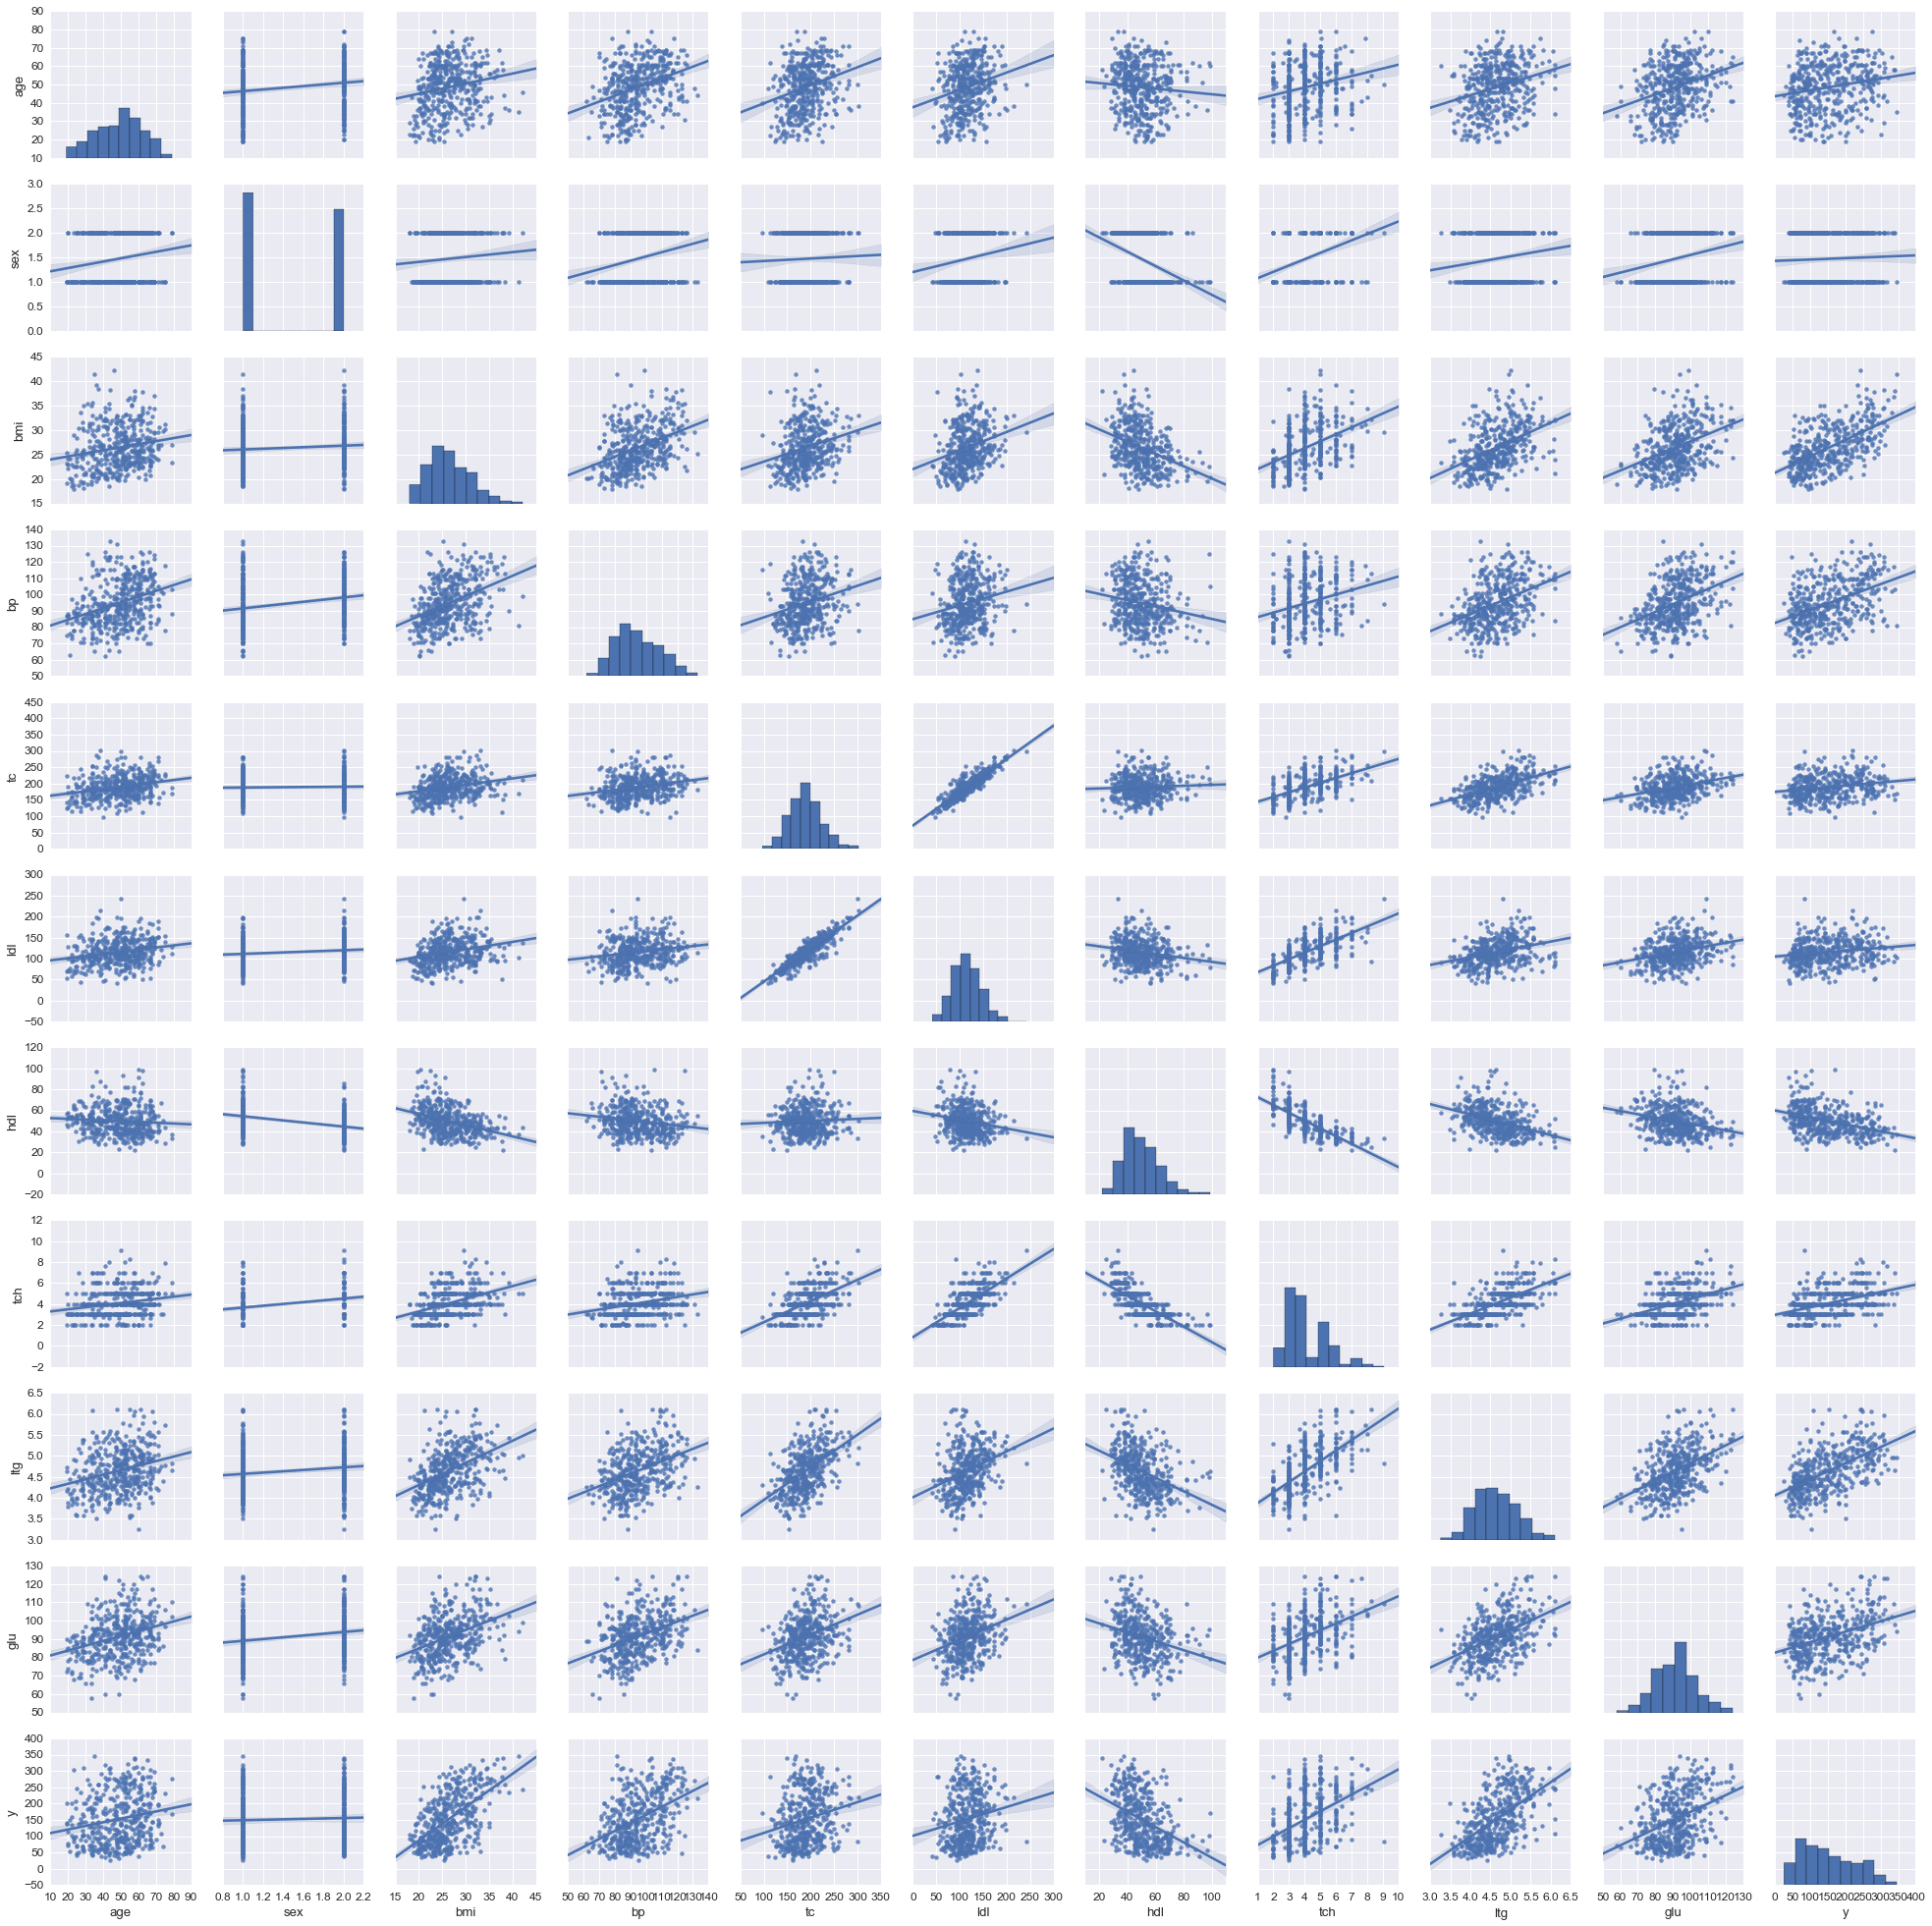

In [3]:
import seaborn as sns
sns.set(font_scale=1.2)
g = sns.pairplot(data, kind='reg')

## OLS model with full sample
Let's start off with something familiar. We'll fit an ordinary least-squares (OLS) regression to all the data, predicting diabetes outcome from the 10 other variables. We'll use the statsmodels packages, which is the closest Python analog to much of base R's statistics functionality.

In [4]:
# Create a copy of the data so we don't tamper with the original,
# since we'll use other packages later that may require
# different preprocessing steps.
X = data.copy()

# Remove outcome from the predictor matrix
y = X.pop('y')

# Add intercept--SM won't do this for us
X_ = sm.add_constant(X)

# Fit model and sumarize results
model = sm.OLS(y, X_)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     46.27
Date:                Wed, 13 Jul 2016   Prob (F-statistic):           3.83e-62
Time:                        09:04:11   Log-Likelihood:                -2386.0
No. Observations:                 442   AIC:                             4794.
Df Residuals:                     431   BIC:                             4839.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       -334.5671     67.455     -4.960      0.000      -467.148  -201.986
age           -0.0364      0.217     -0.168      0.867        -0.463     0.390
sex          -22.8596      5.836     -3.917      0.000       -34.330   -11.389
bmi            5.6030      0.717      7.813      0.000         4.194     7.012
bp             1.1168      0.225      4.958      0.000         0.674     1.560
tc            -1.0900      0.573     -1.901      0.058        -2.217     0.037
ldl            0.7465      0.531      1.406      0.160        -0.297     1.790
hdl            0.3720      0.782      0.475      0.635        -1.166     1.910
tch            6.5338      5.959      1.097      0.273        -5.178    18.245
ltg           68.4831     15.670      4.370      0.000        37.685    99.282
glu            0.2801      0.273      1.025      0.306        -0.257     0.817
==============================================================================
Omnibus:                        1.506   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.471   Jarque-Bera (JB):                1.404
Skew:                           0.017   Prob(JB):                        0.496
Kurtosis:                       2.726   Cond. No.                     7.24e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.24e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Fitting models in scikit-learn
The above statsmodels code works fine for OLS regression. But to make our life easier when we start fitting other kinds of estimators (e.g., lasso or ridge regression), let's switch to the [scikit-learn package](http://scikit-learn.org) (sklearn), which has the benefit of providing a simple, consistent interface to virtually all of the estimators it supports out of the box.

Here's what OLS regression looks like in sklearn. Note that we don't get all of the nice summary output statsmodels provides. But since we don't really care about most of that stuff for present purposes, we'll just print the model's $R^2$ and verify that it matches the statsmodels output.

In sklearn, most estimators implement a score() method that provides a default scoring function. For regression-based estimators like OLS, the $R^2$ is the default scoring method. However, the `metrics` module in sklearn also includes a large number of other metrics we can easily use to evaluate performance. In this case, one could argue that root-mean-squared-error (RMSE) is a better performance metric than $R^2$, because the former tells us how good our predictions are in an absolute sense (i.e., in units of the original outcome variable), whereas the latter only tells us how much of the variation in the original sample we're capturing. We'll display both metrics.

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# In sklearn, we need to instantiate each estimator
# before we can apply it to data. Note that we set
# fit_intercept to False because we've already manually
# added the intercept to the predictor matrix.
est = LinearRegression()

# Now we fit the data...
est.fit(X, y)

# For LinearRegression, the default scoring method is R^2.
# This should match the output of statsmodels.
print("R^2: %.3f" % est.score(X, y))

# Let's also display the root mean squared error (RMSE)
y_pred = est.predict(X)
rmse = np.sqrt(mean_squared_error(y, y_pred))
print("RMSE: %.3f" % rmse)

R^2: 0.518
RMSE: 53.476


/Users/tal/anaconda/lib/python3.5/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


## Overfitting
The raw $R^2$ estimate produced by OLS (or most other estimators) is an imperfect measures of the model's true prediction capacity. In general, the estimate will be upwardly biased, because we're evaluating the model's performance on the same data we used to train the model in the first place. As discussed in the main text of Yarkoni & Westfall (2016), the degree to which the model overfits the data depends to a large extent on the flexibility of the model relative to the amount of data available. In this case, we have 442 cases and 10 predictors, so the amount of overfitting is likely to be minimal (we can get a preliminary sense of that by noting that the raw $R^2$ value of .52 only drops very slightly--to .51--when analytically adjusted for the number of predictors and cases). But let's quantify that directly, by repeatedly fitting and evaluating the model in independent samples. This is known as "out-of-sample" testing. In this case, we'll repeatedly split the sample in two random halves. We'll use the "training" half to fit the model, and then apply the fitted model to the "testing" half to obtain a less biased estimate of out-of-sample prediction accuracy.

In [6]:
# We'll do 1000 random train/test splits
REPS = 1000

# Save both R^2 and RMSE
r2_reps = np.zeros(REPS)
rmse_reps = np.zeros(REPS)
n = len(data)

est = LinearRegression()

for i in range(REPS):
    # Randomly get half the indices to use for training
    inds = np.random.choice(n, n/2, False)
    # Split dataset into training/testing samples
    X_train, X_test = X.values[inds], X.values[~inds]
    y_train, y_test = y.values[inds], y.values[~inds]
    
    # Fit model on training data and apply to test data
    est.fit(X_train, y_train)
    r2 = est.score(X_test, y_test)

    y_pred = est.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Append to result arrays
    r2_reps[i] = r2
    rmse_reps[i] = rmse
    
print("R^2: %.3f" % r2_reps.mean())
print("RMSE: %.3f" % rmse_reps.mean())

/Users/tal/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


R^2: 0.505
RMSE: 54.110


As you can see, in this case, the overfitting is negligible. The $R^2$ drops from around 0.518 in the nominally overfitted model to around 0.505 for the minimally biased, out-of-sample estimate. Likewise, the RMSE only rises from 53.48 to 54.03. This is reassuring, but note that in many cases, the degree of inflation of $R^2$ (or whatever other metric of predictive performance) will be far greater, depending on the balance of *p* (the number of predictors) to *n* (the number of cases). In particular, when p is high relative to n, the gap between training dataset performance and test dataset performance will typically be quite large--a point we will return to later.

## k-folds cross-validation
We can think of the split-half approach we used above as a special case of a more general *k-folds cross-validation* framework, where *k* is the number of "folds" (or splits) in the data. In our approach above, we set *k* to 2. But we could set it to any other value between 2 and *n*. At the limit, if we set *k* equal to *n*, the approach is called *leave-one-out cross-validation* (because in every fold, we leave out a single data point for testing, and use the rest of the dataset for training). In practice, *k* is most commonly set to a value in the range of 3 - 10 (there are principled reasons to want to avoid large values of *k* in most cases, but we won't get into those details here).

To illustrate how k-folds cross-validation works, let's implement it ourselves. First, we create k different subsets of the original dataset. Then, we loop over the k subsets and, in each case, use the current subset to test the model trained on the remaining k-1 subsets. Finally, we average over the performance estimates obtained from all k folds to obtain our overall out-of-sample performance estimate.

In [7]:
K = 5 # number of folds we want

# Initialize results variable and estimator
test_rmse = []
est = LinearRegression()

# Create list of indexes and randomize order
from random import shuffle
inds = list(range(len(X)))
shuffle(inds)

# To simplify indexing, we extract the numpy arrays
# from the pandas DataFrames
_X, _y = X.values, y.values

# Loop over the k folds
for k in range(K):
    # Get the training and testing indices
    train = [x for i, x in enumerate(inds) if i % K != k]
    test = list(set(inds) - set(train))
    
    # Fit the linear regression to only the training data
    est.fit(_X[train], _y[train])
    
    # Now predict scores for the test data
    y_pred = est.predict(_X[test])
    
    # Save the RMSE for this fold
    fold_rmse = mean_squared_error(_y[test], y_pred)
    test_rmse.append(fold_rmse)

rmses = np.sqrt(np.array(test_rmse))
print("Mean RMSE over folds: %.2f" % rmses.mean())

Mean RMSE over folds: 54.92


The above code explicitly illustrates the logic of k-fold cross-validation, and isn't very verbose--but it's still more cumbersome than it needs to be. In practice, we can almost always use the out-of-the-box cross-validation utilities provided in scikit-learn's `cross_validation` module, making our life much easier. Although we won't demonstrate it here, the cross_validation module also includes [a variety of tools](http://scikit-learn.org/stable/modules/cross_validation.html) for more sophisticated kinds of cross-validation (e.g., stratified k-folds, leave-one-label-out, etc.). Here's the sklearn-based equivalent of the previous code cell.

In [8]:
from sklearn.cross_validation import KFold

K = 5

est = LinearRegression()

# Save the results
r2_folds = []
rmse_folds = []

_X, _y = X.values, y.values

# Iterating the KFold object returns tuples of
# randomly shuffled training and testing indices.
for train, test in KFold(n, K, shuffle=True):
    
    # As before: fit on the training data, apply
    # to the test data.
    est.fit(_X[train], _y[train])
    r2 = est.score(_X[test], _y[test])
    r2_folds.append(r2)
    y_pred = est.predict(_X[test])
    rmse = np.sqrt(mean_squared_error(y[test], y_pred))
    rmse_folds.append(rmse)

print("R^2: %.3f" % np.array(r2_folds).mean())
print("RMSE: %.3f" % np.array(rmse_folds).mean())

R^2: 0.469
RMSE: 55.145


As we mentioned above, the degree to which the model overfits the data depends on the flexibility of the model relative to the amount of available data. When the model's degrees of freedoms approach the number of available cases, many models will tend to grossly overfit (though there are approaches like *regularization*, discussed below, that can dramatically reduce overfitting even in the latter type of situation).

To illustrate, let's repeat our OLS analysis using a more flexible model. Instead of predicting disease progression from just the additive effects of the 10 predictors, we'll build a model that also takes polynomial features into account. In other words, in addition to the 10 main effects, the model will add higher-order interactions between different features. For a polynomial fit of order 2, we get 65 features (10 main effects, 10 quadratic effects of each predictor, and 45 interactions between every pair of predictors). For a third-order model, we already have 285 features (the vast majority of which represent 3-way interactions between predictors). The polynomial features allow us to build models that are much more powerful than the simple model we started out with, in the sense that they can now capture all kinds of patterns in the data that our first model couldn't. The downside is that our propensity to overfit the data now increases correspondingly.

To reduce code redundancy, let's abstract the model-fitting logic used above into a flexible method that lets us pass the polynomial degree as a parameter.

In [9]:
# A utility for extracting polynomial features from a set of predictors
from sklearn.preprocessing import PolynomialFeatures

def fit_linear_model(X, y, degree=1, k=5, estimator=LinearRegression(), reps=1):
    '''
    Reports raw (overfitted) R^2 and cross-validated R^2 for any sklearn
    regression-based estimator.
    Args:
        X (ndarray): 2-d array of predictors
        y (ndarray): 1-d vector of outcome values
        degree (int): polynomial order
        k (int, None): optional number of folds to use in cross-validation.
            If None, no cross-validation is performed or reported.
        estimator: A scikit-learn estimator to use in the model fitting.
            Defaults to LinearRegression (i.e., OLS).
        reps (int): Number of train/test splits to average over.
    '''
    X = PolynomialFeatures(degree=degree).fit_transform(X)
    print("Predictor set includes %d features." % X.shape[1])
    n = len(X)

    # Compute (overfitted) R^2 and RMSE on the full dataset
    estimator.fit(X, y)
    r2 = estimator.score(X, y)
    print("\nTraining (overfitted) R^2 (n = %d): %.3f" % (n, r2))
    y_pred = estimator.predict(X)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    print("Training (overfitted) RMSE (n = %d): %.3f" % (n, rmse))

    # Cross-validated R^2
    if k is not None:
        
        r2_reps = np.zeros(reps)
        rmse_reps = np.zeros(reps)
        
        for i in range(reps):

            r2_folds = []
            rmse_folds = []
            
            folds = KFold(len(X), k, shuffle=True)
            for train, test in folds:
                estimator.fit(X[train], y[train])
                
                # R^2
                y_pred = estimator.predict(X[test])
                r2 = np.corrcoef(y_pred, y[test])[0, 1] ** 2
                r2_folds.append(r2)
                
                # RMSE
                rmse = np.sqrt(mean_squared_error(y[test], y_pred))
                rmse_folds.append(rmse)
                
            r2_reps[i] = np.array(r2_folds).mean()
            rmse_reps[i] = np.array(rmse_folds).mean()
            
        cv_r2 = np.array(r2_reps).mean()
        cv_rmse = np.array(rmse_reps).mean()
        print("\nCross-validated R^2 (n = %d, mean of %d folds, %d random train/test splits): %.3f" % (n, k, reps, cv_r2))
        print("Cross-validated RMSE (n = %d, mean of %d folds, %d random train/test splits): %.3f" % (n, k, reps, cv_rmse))

With that done, we can now easily fit an OLS model with an expanded feature set. Let's include all 2-way interactions plus quadratic terms:

In [10]:
fit_linear_model(X, y, 2, reps=100)

Predictor set includes 66 features.

Training (overfitted) R^2 (n = 442): 0.592
Training (overfitted) RMSE (n = 442): 49.161

Cross-validated R^2 (n = 442, mean of 5 folds, 100 random train/test splits): 0.423
Cross-validated RMSE (n = 442, mean of 5 folds, 100 random train/test splits): 60.495


Going from 10 main effects to 66 2nd-order features, two interesting things happen. First, the unadjusted/raw $R^2$ estimate we obtained when evaluating our model's performance on the same data used for training increases noticeably (from around .52 to around .59). A naive interpretation of this result might be that the more flexible model is "better", since it appears to capture more variance. Unfortunately, this improvement turns out to be illusory. When we look at the cross-validated model performance, we find a substantial worsening in both $R^2$ (from around .51 to around .42) and RMSE (from around 54.9 to around 60.8). In other words, the addition of two-way interactions between all features doesn't appear to help us capture much more real signal, but it makes it easier for the model to overfit the data and essentially "hallucinate" patterns in noise.

If we add 3-way interactions, the problem gets much, much worse:

In [11]:
fit_linear_model(X, y, 3, reps=100)

Predictor set includes 286 features.

Training (overfitted) R^2 (n = 442): 0.798
Training (overfitted) RMSE (n = 442): 34.604

Cross-validated R^2 (n = 442, mean of 5 folds, 100 random train/test splits): 0.023
Cross-validated RMSE (n = 442, mean of 5 folds, 100 random train/test splits): 504.481


In this case, the gap between the overfitted and cross-validated estimates of model performance is remarkably large. The naive estimate would lead us to believe that the model captures approximately 80% of the variance in 1-year diabetes disease progression, and has an RMSE of only 34.6. In reality, our more complex model is almost completely useless for out-of-sample prediction: the $R^2$ is near 0, and the RMSE of ~500 is hideously large (to put this in perspective, it's several times bigger than what we would get if we simply predicted the sample mean for every observation). This result underscores how pernicious overfitting can be: the problem isn't just that overfitted results look too optimistic; it's also that an overfitted model is likely to generalize to new data much more poorly than a different model trained on the same data might have been able to.
 
The upshot is that k-folds cross-validation provides a simple, efficient, and relatively unbiased way to assess the out-of-sample performance of a given model without having to collect any more data. Importantly, virtually any kind of analysis that produces a summary metric of model performance can be cross-validated--typically using virtually identical procedures. This contrasts with analytical corrections for overfitting, which are typically specific to the model in question, and may depend on unreasonably strong assumptions.

## Regularization
Cross-validation is helpful for quantifying the extent to which a model is overfitting the data. But it's of limited utility in actually _improving_ model performance (though it can be indirectly helpful by facilitating selection of model parameters, as we discuss in more detail later). Fortunately, many common estimators can be *regularized* by imposing formal constraints that bias the fitted solution towards parts of the parameter space that are less likely to overfit. The most common regularization approach in the context of regression models is known as *penalized regression*. The two most common forms of penalized regression are lasso regression and ridge regression (for further discussion, see the main text of Yarkoni & Westfall (2016), or the much better and fuller treatment in [Elements of Statistical Learning](http://statweb.stanford.edu/~tibs/ElemStatLearn/)).

Practically speaking, fitting a model using lasso or ridge regression in scikit-learn is just as easy as fitting an OLS model. We simply replace the LinearRegression estimator with another estimator like Ridge or Lasso. For example:

In [12]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import scale

est = Lasso(alpha=0.05)

# Penalized regression is sensitive to variable scale,
# so we standardize the columns of the X matrix.
scaled_X = scale(X)

est.fit(scaled_X, y)
r2 = est.score(scaled_X, y)
print(r2.round(3))

0.518


Note that, unlike the LinearRegression object, which has no free parameters, the Lasso object takes an `alpha` argument that represents the size of the penalty term (if a value is not explicitly passed, a default value of 1.0 
will be used). The larger the value, the greater the model's emphasis on sparsity--meaning that, at high values, the lasso will "zero out" a larger number of predictors, retaining only a small set of the most important coefficients. When alpha is 0, the model is formally equivalent to OLS regression.

We can now use the handy fit_linear_model() method we wrote earlier to easily evaluate the performance of lasso and ridge regression in the context of the various predictor sets we previously examined with OLS regression. Let's start with the simple model that includes only the main effects of the 10 variables (plus an intercept). Notice that we now pass a Lasso estimator to the `estimator` argument of our method. Because all `scikit-learn` regression estimators have the same fit()-based interface, we don't need to change anything else in our code. (Note though that we're passing in a version of the X matrix that has standardized columns, because the penalty term is sensitive to the scale of the input variables.)

In [13]:
# Initialize the lasso estimator with the default penalty of 1.0
est = Lasso(alpha=1.0)
# Fit the model and print results
fit_linear_model(scaled_X, y, 1, estimator=est, reps=100)

Predictor set includes 11 features.

Training (overfitted) R^2 (n = 442): 0.513
Training (overfitted) RMSE (n = 442): 53.723

Cross-validated R^2 (n = 442, mean of 5 folds, 100 random train/test splits): 0.496
Cross-validated RMSE (n = 442, mean of 5 folds, 100 random train/test splits): 54.818


The cross-validated estimate for lasso regression should in this case be very close to what we would get if we used `LinearRegression`, because the p-to-n (i.e., variables-to-samples) ratio is quite low in this case, and we're using a pretty conservative value of `alpha`. As discussed in the main text, when we're in a data-rich scenario, the incremental benefit of penalized regression over OLS regression is likely to be relatively limited.

On the other hand, consider what happens if we apply the lasso to the expanded set of 286 3rd-order features:

In [14]:
# Initialize the lasso estimator with the default penalty of 1.0
est = Lasso(alpha=1.0)
# Fit the model and print results
fit_linear_model(scaled_X, y, 3, estimator=est, reps=100)

Predictor set includes 286 features.

Training (overfitted) R^2 (n = 442): 0.623
Training (overfitted) RMSE (n = 442): 47.264

Cross-validated R^2 (n = 442, mean of 5 folds, 100 random train/test splits): 0.414
Cross-validated RMSE (n = 442, mean of 5 folds, 100 random train/test splits): 60.418


Notice how, in contrast to OLS, the lasso model successfully maintains a reasonably good capacity to predict out-of-sample diabetes outcomes even in the face of a very large feature set (i.e., the full set of 3rd-order polynomial features). The intuitive reason for this is that the lasso implicitly performs feature selection--that is, it will discard from the model those predictors that are highly redundant with other more informative predictors. Thus, most of the ~250 2-way and 3-way interaction terms will drop out during the estimation process, making estimation of the remaining coefficients more stable.

### Model selection
As we noted above, the lasso estimator takes a single key free parameter--`alpha`, the size of the penalty term. In the above examples, we used the default penalty of 1.0. But there's no principled reason for this, and you might already be wondering just how much of an impact the value of `alpha` has on the results we obtain. The answer is "it depends". If we consider the full range of possible values of alpha, it should be intuitively clear that the results can and will change dramatically. To see this, first consider what happens if we set alpha to 0. In this case, the lasso regression simply reduces to OLS, so model performance in the preceding example (with 286 features) will be exactly as bad as what we saw for OLS--and much worse than the performance we obtain with the default alpha of 1.0.

At the other extreme, consider what happens if we pick a very large value of alpha--say, 1,000. In this case, we're effectively saying that virtually the only thing we care about is that our model should produce an extremely sparse solution. We don't really care about the traditional squared error term (which is what OLS regression seeks to minimize), since it's almost certainly going to be dwarfed by the huge penalty we're attaching to non-zero coefficients. What this means is that the prediction equation we end up with is all but guaranteed to retain a very small number of variables. We can make this more concrete by plotting the number of retained variables against values of `alpha`:

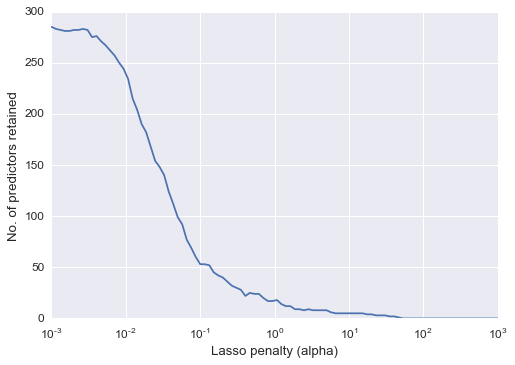

In [15]:
alphas = np.logspace(-3, 3, 100)

n_coefs = np.zeros(len(alphas))

poly_X = PolynomialFeatures(degree=3).fit_transform(X)
poly_X = scale(poly_X)

for i, a in enumerate(alphas):
    est = Lasso(a)
    est.fit(poly_X, y)
    n_coefs[i] = len(np.nonzero(est.coef_)[0])

plt.semilogx(alphas, n_coefs)
plt.xlabel('Lasso penalty (alpha)')
plt.ylabel('No. of predictors retained')

Notice that, if the penalty gets high enough (in this case, around alpha = 50), the model will retain *none* of the predictors--effectively predicting the outcome from only the intercept. Needless to say, this is not a good thing. But even before that happens, performance is likely to decline precipitously, because it's unlikely that diabetes outcome can be accurately predicted using only a very small number of variables. For example, here's what happens if we set alpha to 30:

In [16]:
est = Lasso(alpha=50)
est.fit(poly_X, y)
print("Number of non-zero coefficients: %d" % len(np.nonzero(est.coef_)[0]))
y_pred = est.predict(poly_X)
rmse = np.sqrt(mean_squared_error(y, y_pred))
print("RMSE: %.2f" % rmse)

Number of non-zero coefficients: 1
RMSE: 75.16


An RMSE of 75.16 might not seem so bad at first glance, but consider that if we simply predicted the same constant value for each of the `y` scores (namely, the mean, or intercept), we would obtain almost the same error:

In [17]:
y_pred = np.ones(len(y)) * y.mean()
rmse = np.sqrt(mean_squared_error(y, y_pred))
print("RMSE: %.2f" % rmse)

RMSE: 77.01


Let's more systematically examine out-of-sample performance as a function of the penalty. The plot below displays coefficient paths (top) and out-of-sample model performance (in terms of RMSE; bottom) for different values of alpha (ranging from 0.001 to 100). Error bars in the bottom plot display 95% CIs, and the dashed line displays the RMSE for OLS for reference. 

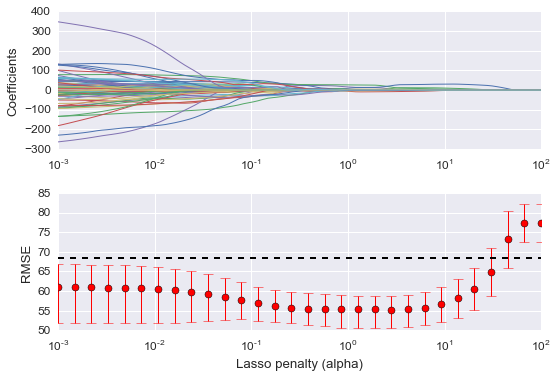

In [18]:
from sklearn.linear_model import lasso_path
from sklearn.cross_validation import ShuffleSplit, cross_val_score
from sklearn.learning_curve import validation_curve

# Set up 2-row plot
fig, axes = plt.subplots(2, 1)

# For the sake of visual clarity, use order 2 rather than 3
poly_X = PolynomialFeatures(degree=2).fit_transform(X)
poly_X = scale(poly_X)

# Plot coefficient path
alphas = np.logspace(2, -3, 100)
alphas, paths, _ = lasso_path(poly_X, y, alphas=alphas)
_ = axes[0].plot(alphas, paths.T, lw=1.)
axes[0].set(xscale='log', ylabel='Coefficients')

# # Plot RMSE
random_splitter = ShuffleSplit(len(y), 100, 0.5)
alphas = np.logspace(2, -3, 30)
train_scores, test_scores = validation_curve(Lasso(max_iter=1000), poly_X, y, 'alpha', alphas,
                                             scoring='mean_squared_error', cv=random_splitter)

# the sklearn API always minimizes metrics, so we invert sign
test_scores = np.sqrt(-test_scores)
# Get 95% CI
means = test_scores.mean(1)
tiles = means - np.percentile(test_scores, [0.025, 0.975], 1)

axes[1].errorbar(alphas, means, tiles, fmt='ro', elinewidth=1, mew=0.5, capsize=5)
axes[1].set(xscale='log', xlabel='Lasso penalty (alpha)', ylabel='RMSE')

# Add OLS RMSE as a baseline
rmse = cross_val_score(LinearRegression(), poly_X, y, scoring='mean_squared_error', cv=random_splitter)
rmse = np.sqrt(-rmse).mean()
axes[1].hlines(rmse, alphas.min(), alphas.max(), linewidths=2, linestyles='--')

plt.tight_layout()

The key point to note here is that while lasso regression produces better out-of-sample performance for a wide range of alpha values, its performance is worse than that of OLS when the penalty term is set fairly high (approximately 30 and above). This underscores the "no free lunch" principle discussed in Yarkoni & Westfall (2016): there is no single estimator (or even family of estimators) that always performs well on every dataset. Obtaining good predictions often requires one to carefully tune the parameters of one's model to best match the available data.

## Nested cross-validation
The observation that an estimator's predictive performance usually depends to a significant extent on careful parameter tuning raises two potentially serious concerns. First, doesn't the ability to tune the estimator by fiddling with a bunch of additional knobs open the door to exactly the kind of p-hacking or *procedural overfitting* we warn against in Yarkoni & Westfall (2016)? And second, how is one supposed to identify the optimal value of the parameters anyway, given that the search space is often very large?

Let's take these one at a time. First, it's true that overfitting can and frequently does occur at the parameter tuning (or, more generally, model selection) stage. As discussed in the main text, it's not uncommon to see researchers set the free parameters of their model by testing a range of values and picking the ones that produce the best cross-validated results. At face value, this might seem like a defensible strategy: since we always cross-validate each of the model variants we test, overfitting shouldn't be a problem, right? Unfortunately, it doesn't quite work that way. While this approach will do a good job controlling overfitting related to the estimation process *within* each cross-validation application, it's still likely to overfit at the point of selection *between* a large number of potential models.

This brings us to our second problem: if we aren't allowed to choose our parameters based on systematic comparison of cross-validated performance across many possible values, how are we supposed to choose optimal--or at least, good--values? Fortunately, there's a simple and effective solution to this problem: nested cross-validation. The basic idea here is to optimize the values of the free parameters of our estimator *within* the existing cross-validation loop(s). In this way, we avoid biasing the out-of-sample estimates.

Concretely, this just means that instead of one cross-validation loop, we now have two. In the outer loop, we do our standard cross-validation procedure: we repeatedly use, say, 4/5ths of the data to train the model, and then test it on the remaining 1/5th. Then we average over the 5 folds. The difference is that we now add another inner loop, which we use to set our free parameter(s). In other words, we take the 4/5ths of the dataset we've designated for training, and we now create *another* cross-validation loop. Within that loop, we use (say) 4/5ths of the training data to fit a model with a particular set of parameters, and we test the performance of that model on the remaining 1/5th of the training data. We repeat this process for some (typically large) space of possible parameter values (when we have multiple parameters, this approach is called a "grid search", because we're typically exploring all possible combinations of the levels of different parameters). We then select the parameter values that give us the best out-of-sample performance *within* the training data, and apply those to the original test data.

Note that one interesting implication of nested cross-validation is that the "optimal" values of our free parameters can (and typically, will) change somewhat across folds, due purely to sampling error. This means that you can't generally use nested cross-validation to *identify* the optimal parameters, but only to determine approximately how well an optimal model would perform when evaluated in a truly cross-validated way.

Anyway, that's a lot of words. The good news is, the actual code to do nested cross-validation is very minimal, if you're using scikit-learn. Out of the box, you get cross-validated versions of many of the common estimators like Lasso and Ridge, so selecting optimal parameters is typically as easy as providing the set of values to search over.

Here's what the code looks like if we're explicit. Note that it's virtually identical to our earlier cross-validation example (without nesting). The only real difference between these two cases is that we're using `LassoCV` instead of `Lasso`.

In [19]:
from sklearn.linear_model import LassoCV

K = 5

# By default, LassoCV will try out 100 different alpha values
# over a reasonable range. But we could also manually specify
# which values we want to test by passing to the alphas argument.
est = LassoCV()

# Save the results
r2_folds = []
rmse_folds = []

_X, _y = X.values, y.values

# Iterating the KFold object returns tuples of
# randomly shuffled training and testing indices.
for train, test in KFold(n, K, shuffle=True):
    
    # As before: fit on the training data, apply
    # to the test data.
    est.fit(_X[train], _y[train])
    r2 = est.score(_X[test], _y[test])
    r2_folds.append(r2)
    y_pred = est.predict(_X[test])
    rmse = np.sqrt(mean_squared_error(y[test], y_pred))
    rmse_folds.append(rmse)

print("R^2: %.3f" % np.array(r2_folds).mean())
print("RMSE: %.3f" % np.array(rmse_folds).mean())

R^2: 0.483
RMSE: 55.271


Of course, since we've already written our own cross-validation wrapper that does a bunch of useful stuff, we could also just pass the LassoCV estimator directly to our function.

In [20]:
fit_linear_model(scaled_X, y, 2, estimator=LassoCV(), k=2, reps=100)

Predictor set includes 66 features.

Training (overfitted) R^2 (n = 442): 0.530
Training (overfitted) RMSE (n = 442): 52.784

Cross-validated R^2 (n = 442, mean of 2 folds, 100 random train/test splits): 0.482
Cross-validated RMSE (n = 442, mean of 2 folds, 100 random train/test splits): 55.975


The nested cross-validation procedure turns out to be pretty effective in this case--performance is in the same ballpark as the single best value we observed in the plot above. In general, nested cross-validation will produce results that are almost as good as the true optimum. Unless you're working with obscene amounts of data, performance will rarely actually be optimal, because the price you pay for all that cross-validation and data splitting is some degree of *underfitting*. This once again underscores the no-free-lunch principle: if you have reason to think you already know what good values of your free parameters might be, you should use those instead of trying to do a comprehensive search (or at least, focus the grid search on more plausible values of the space).